In [13]:
import pyspark
import findspark
print(findspark.init())
print(findspark.find())

spark = pyspark.sql.SparkSession.builder.appName('MySpark').getOrCreate()

from pyspark.sql.types import * #StructType, StringType, IntegerType
schema = StructType([
   StructField("name", StringType(), True),
   StructField("number", IntegerType(), True)]
)
df_spark = spark.createDataFrame(
    data=[('Java', 10), ('Python', 20), ('JS', 30)],
    schema=schema
)
print(df_spark.printSchema())
df_spark.show()

None
C:\Users\echernoskutov\anaconda3\lib\site-packages\pyspark
root
 |-- name: string (nullable = true)
 |-- number: integer (nullable = true)

None
+------+------+
|  name|number|
+------+------+
|  Java|    10|
|Python|    20|
|    JS|    30|
+------+------+



### Datamart generator and calendar


#### ref cols:

- project_name text,
- subscription_name text,
- resource_group_name text,
- size_mb,percent_size,
- billing_year int,
- billing_month int,
- billing_day int


1. В репозитории cost_tracker_demo в Notebook-е "generate_synthetic_data" добавить скрипт, 
2. который на основании данных за 19 Февраля 2023 в витрине DATA_MARTS / dm_storage_usage сгенерирует данные до 1 Января 2022 года. 
3. Данные о хранении должны уменьшатся и иногда резко увеличиваться.

1. Формат хранения - Parquet
2. Пaртицирование: billing_year / billing_month / billing_day


#### Design:

1. constant:
2. create calendar
3. create dict
4. data transform 
5. load data
    - ds_result save to storage

In [0]:
# constant:
C_START_DATE = "2022-01-01"
C_END_DATE = "2023-01-01"
C_TARGET_DATAMART_PATH= "/mnt/mount_dir/DATA_MARTS/dm_storage_usage"

C_START_COST = 1000
C_END_COST = 15000
C_LOWER_BOUND_RATIO = 1
C_RATIO_DIFF = 0.25


# -- import 
from datetime import date
from datetime import datetime  
from datetime import timedelta  
from random import random
import pandas as pds
import numpy as np
# import fastparquet

# -- create calendar
p_end = date.fromisoformat(C_END_DATE)
p_start = date.fromisoformat(C_START_DATE)
between_s_e_date = p_end - p_start

date_ls_s_to_e = list()
v_itter_cnt = int(between_s_e_date.days)
for i in range(v_itter_cnt):
    next_date = p_start + timedelta(days=i)
    v_id = i+1
    v_itter_step = abs(C_END_COST-C_START_COST)/(v_itter_cnt-1)
    v_crnt_cost = (v_crnt_cost + v_itter_step) if (i != 0) else C_START_COST
    v_ratio_diff_step = C_LOWER_BOUND_RATIO + (C_RATIO_DIFF * random())
    v_is_switcher_diff = 1 if random() >= 0.5 else -1
    date_ls_s_to_e.append(
        [
            v_id, round(v_crnt_cost), 
            round(v_ratio_diff_step, 2), 
            v_is_switcher_diff,
            next_date.strftime("%Y-%m-%d"),
            int(next_date.year),
            int(next_date.month),
            int(next_date.day)
        ]
    )
    
# date_ls_s_to_e
# [[1, 1000, 1.09, 1, '2022-01-01', 2022, 1, 1],
#  [2, 1272, 2.25, 1, '2022-01-02', 2022, 1, 2],
#  [3, 1544, 1.34, -1, '2022-01-03', 2022, 1, 3],

In [0]:
data_name_cols = ['project_name', 'subscription_name', 'resource_group_name']
data_dict = [
    ['Cost-Tracker-Demo', 'subscription_presalesteinmark', 'costtrackerdemo'],
    ['CI-CD-Demo', 'subscription_presalesteinmark', 'costtrackerdemo_realloc']
]
df_dict = pds.DataFrame(data=data_dict, columns=data_name_cols)

df_dict

,project_name,subscription_name,resource_group_name
0,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo
1,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc


In [0]:
data_name_cols = ['id', 'cost', 'ratio', 'is_switcher_diff', 'dt', 'billing_year', 'billing_month', 'billing_day']
df_calendar = pds.DataFrame(data=date_ls_s_to_e, columns=data_name_cols)

df_calendar.head()

,id,cost,ratio,is_switcher_diff,dt,billing_year,billing_month,billing_day
0,1,1000,1.12,-1,2022-01-01,2022,1,1
1,2,1038,1.14,1,2022-01-02,2022,1,2
2,3,1077,1.17,1,2022-01-03,2022,1,3
3,4,1115,1.06,1,2022-01-04,2022,1,4
4,5,1154,1.20,-1,2022-01-05,2022,1,5


In [0]:
df_tmp_report = df_calendar.merge(right=df_dict, how='cross')

df_tmp_report.head()

,id,cost,ratio,is_switcher_diff,dt,billing_year,billing_month,billing_day,project_name,subscription_name,resource_group_name
0,1,1000,1.12,-1,2022-01-01,2022,1,1,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo
1,1,1000,1.12,-1,2022-01-01,2022,1,1,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc
2,2,1038,1.14,1,2022-01-02,2022,1,2,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo
3,2,1038,1.14,1,2022-01-02,2022,1,2,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc
4,3,1077,1.17,1,2022-01-03,2022,1,3,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo


In [0]:
# -- is_switcher_diff inversion
df_tmp_report.is_switcher_diff = np.where((df_tmp_report.project_name=='Cost-Tracker-Demo') &
    (df_tmp_report.subscription_name=='subscription_presalesteinmark') &
    (df_tmp_report.resource_group_name=='costtrackerdemo'), df_tmp_report.is_switcher_diff, df_tmp_report.is_switcher_diff * -1)

df_tmp_report.head()

,id,cost,ratio,is_switcher_diff,dt,billing_year,billing_month,billing_day,project_name,subscription_name,resource_group_name
0,1,1000,1.12,-1,2022-01-01,2022,1,1,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo
1,1,1000,1.12,1,2022-01-01,2022,1,1,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc
2,2,1038,1.14,1,2022-01-02,2022,1,2,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo
3,2,1038,1.14,-1,2022-01-02,2022,1,2,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc
4,3,1077,1.17,1,2022-01-03,2022,1,3,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo


In [0]:
def do_calculation_cost(p_cost, p_ratio, p_is_switcher_diff):
    v_calculation_cost = 0.00
#     TODO: need to improve the algorithm:
    v_calculation_cost = p_cost + (p_cost * (p_ratio-1) * p_is_switcher_diff)
    v_calculation_cost = 0 if v_calculation_cost<0 else v_calculation_cost
    return round(v_calculation_cost, 2)

df_tmp_report['size_mb'] = df_tmp_report.apply(lambda row: do_calculation_cost(row.cost, row.ratio, row.is_switcher_diff), axis=1)

df_tmp_report.head()

,id,cost,ratio,is_switcher_diff,dt,billing_year,billing_month,billing_day,project_name,subscription_name,resource_group_name,size_mb
0,1,1000,1.12,-1,2022-01-01,2022,1,1,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,880.00
1,1,1000,1.12,1,2022-01-01,2022,1,1,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,1120.00
2,2,1038,1.14,1,2022-01-02,2022,1,2,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,1183.32
3,2,1038,1.14,-1,2022-01-02,2022,1,2,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,892.68
4,3,1077,1.17,1,2022-01-03,2022,1,3,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,1260.09


In [0]:
# calculate totle sum of one date and all group 
df_report_gr_id_size = df_tmp_report[['id','size_mb']].groupby(['id'], as_index=False).sum().copy()
df_report_gr_id_size = df_report_gr_id_size.rename(columns={"size_mb": "sum_size_mb"})
df_report_gr_id_size.head()

,id,sum_size_mb
0,1,2000.0
1,2,2076.0
2,3,2154.0
3,4,2230.0
4,5,2308.0


In [0]:
df_tmp_report = df_tmp_report.merge(df_report_gr_id_size, how='left', left_on='id', right_on='id')
df_tmp_report.head()

,id,cost,ratio,is_switcher_diff,dt,billing_year,billing_month,billing_day,project_name,subscription_name,resource_group_name,size_mb,sum_size_mb
0,1,1000,1.12,-1,2022-01-01,2022,1,1,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,880.00,2000.0
1,1,1000,1.12,1,2022-01-01,2022,1,1,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,1120.00,2000.0
2,2,1038,1.14,1,2022-01-02,2022,1,2,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,1183.32,2076.0
3,2,1038,1.14,-1,2022-01-02,2022,1,2,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,892.68,2076.0
4,3,1077,1.17,1,2022-01-03,2022,1,3,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,1260.09,2154.0


In [0]:
# Add percent_size
df_tmp_report['percent_size'] =  100*(df_tmp_report.size_mb/df_tmp_report.sum_size_mb)
# Add row_number partition by date ORDER BY cols list
df_tmp_report['gr_pgkt'] = df_tmp_report.sort_values(['project_name', 'subscription_name', 'resource_group_name'], ascending=True).groupby(['dt']).cumcount() + 1
df_tmp_report.head()

,id,cost,ratio,is_switcher_diff,dt,billing_year,billing_month,billing_day,project_name,subscription_name,resource_group_name,size_mb,sum_size_mb,percent_size,gr_pgkt
0,1,1000,1.12,-1,2022-01-01,2022,1,1,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,880.00,2000.0,44.0,2
1,1,1000,1.12,1,2022-01-01,2022,1,1,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,1120.00,2000.0,56.0,1
2,2,1038,1.14,1,2022-01-02,2022,1,2,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,1183.32,2076.0,57.0,2
3,2,1038,1.14,-1,2022-01-02,2022,1,2,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,892.68,2076.0,43.0,1
4,3,1077,1.17,1,2022-01-03,2022,1,3,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,1260.09,2154.0,58.5,2


In [0]:
# extract target columns
df_report = df_tmp_report[[
    'id', 'gr_pgkt', 'dt', 'project_name', 'subscription_name', 'resource_group_name', 'size_mb', 'percent_size', 'billing_year',
    'billing_month', 'billing_day'
]].copy()
df_report.rename(columns={'id':'gr_id_date'}, inplace=True)
df_report.head()

,gr_id_date,gr_pgkt,dt,project_name,subscription_name,resource_group_name,size_mb,percent_size,billing_year,billing_month,billing_day
0,1,2,2022-01-01,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,880.00,44.0,2022,1,1
1,1,1,2022-01-01,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,1120.00,56.0,2022,1,1
2,2,2,2022-01-02,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,1183.32,57.0,2022,1,2
3,2,1,2022-01-02,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,892.68,43.0,2022,1,2
4,3,2,2022-01-03,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,1260.09,58.5,2022,1,3


In [0]:
df_report = df_tmp_report[[
    'id', 'gr_pgkt', 'dt', 'project_name', 'subscription_name', 'resource_group_name', 'size_mb', 'percent_size', 'billing_year',
    'billing_month', 'billing_day'
]].copy()
df_report.rename(columns={'id':'gr_id_date', 'dt':'billing_date'}, inplace=True)
df_report['meter_category'] = 'Storage'
df_report.head()

,gr_id_date,gr_pgkt,billing_date,project_name,subscription_name,resource_group_name,size_mb,percent_size,billing_year,billing_month,billing_day,meter_category
0,1,2,2022-01-01,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,880.00,44.0,2022,1,1,Storage
1,1,1,2022-01-01,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,1120.00,56.0,2022,1,1,Storage
2,2,2,2022-01-02,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,1183.32,57.0,2022,1,2,Storage
3,2,1,2022-01-02,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,892.68,43.0,2022,1,2,Storage
4,3,2,2022-01-03,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,1260.09,58.5,2022,1,3,Storage


In [0]:
# SAVE THROUGH PYTHON ONLY
# df_report.to_parquet(path='./parquet',partition_cols=['billing_year','billing_month','billing_day'] ) -- не перезаписывает

# fastparquet.write(
#     C_TARGET_DATAMART_PATH, df_report, compression='SNAPPY',  partition_on=['billing_year','billing_month','billing_day'],
#     append=False,
#     file_scheme='hive'
# )

# SAVE THROUGH spark:
sparkDF=spark.createDataFrame(df_report[['billing_date', 'project_name', 'subscription_name', 'resource_group_name', 'meter_category', 'size_mb', 'percent_size', 'billing_year',
    'billing_month', 'billing_day']]) 
sparkDF.printSchema()
sparkDF.show()

sparkDF.write.partitionBy('billing_year','billing_month','billing_day').mode("overwrite").parquet(C_TARGET_DATAMART_PATH)

# END datamart

root
 |-- billing_date: string (nullable = true)
 |-- project_name: string (nullable = true)
 |-- subscription_name: string (nullable = true)
 |-- resource_group_name: string (nullable = true)
 |-- meter_category: string (nullable = true)
 |-- size_mb: double (nullable = true)
 |-- percent_size: double (nullable = true)
 |-- billing_year: long (nullable = true)
 |-- billing_month: long (nullable = true)
 |-- billing_day: long (nullable = true)

+------------+-----------------+--------------------+--------------------+--------------+-------+-----------------+------------+-------------+-----------+
|billing_date|     project_name|   subscription_name| resource_group_name|meter_category|size_mb|     percent_size|billing_year|billing_month|billing_day|
+------------+-----------------+--------------------+--------------------+--------------+-------+-----------------+------------+-------------+-----------+
|  2022-01-01|Cost-Tracker-Demo|subscription_pres...|     costtrackerdemo|       Stora

In [0]:
%sql
create or replace view cost_tracker_db.view_dm_storage_usage
as
select * from parquet.`/mnt/mount_dir/DATA_MARTS/dm_storage_usage`;

In [0]:
%sql
SELECT * FROM cost_tracker_db.view_dm_storage_usage;

billing_date,project_name,subscription_name,resource_group_name,meter_category,size_mb,percent_size,billing_year,billing_month,billing_day
2022-07-17,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,Storage,8577.0,50.0,2022,7,17
2022-07-17,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,Storage,8577.0,50.0,2022,7,17
2022-01-27,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,Storage,2000.0,50.0,2022,1,27
2022-01-27,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,Storage,2000.0,50.0,2022,1,27
2022-10-15,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,Storage,12038.0,50.0,2022,10,15
2022-10-15,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,Storage,12038.0,50.0,2022,10,15
2022-11-24,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,Storage,13577.0,50.0,2022,11,24
2022-11-24,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,Storage,13577.0,50.0,2022,11,24
2022-03-24,Cost-Tracker-Demo,subscription_presalesteinmark,costtrackerdemo,Storage,4154.0,50.0,2022,3,24
2022-03-24,CI-CD-Demo,subscription_presalesteinmark,costtrackerdemo_realloc,Storage,4154.0,50.0,2022,3,24


#### data analyze:

In [0]:
df_read_test = spark.read.parquet(C_TARGET_DATAMART_PATH)
df_read_test.printSchema()
df_read_test.show()

root
 |-- billing_date: string (nullable = true)
 |-- project_name: string (nullable = true)
 |-- subscription_name: string (nullable = true)
 |-- resource_group_name: string (nullable = true)
 |-- size_mb: double (nullable = true)
 |-- percent_size: double (nullable = true)
 |-- billing_year: integer (nullable = true)
 |-- billing_month: integer (nullable = true)
 |-- billing_day: integer (nullable = true)

+------------+-----------------+--------------------+--------------------+--------+-----------------+------------+-------------+-----------+
|billing_date|     project_name|   subscription_name| resource_group_name| size_mb|     percent_size|billing_year|billing_month|billing_day|
+------------+-----------------+--------------------+--------------------+--------+-----------------+------------+-------------+-----------+
|  2022-07-17|Cost-Tracker-Demo|subscription_pres...|     costtrackerdemo|  8577.0|             50.0|        2022|            7|         17|
|  2022-07-17|       CI-

In [0]:
# plot analyze:
df = df_report.copy()
df[['gr_pgkt', 'billing_date', 'size_mb']].head(10)

,gr_pgkt,billing_date,size_mb
0,2,2022-01-01,880.00
1,1,2022-01-01,1120.00
2,2,2022-01-02,1183.32
3,1,2022-01-02,892.68
4,2,2022-01-03,1260.09
5,1,2022-01-03,893.91
6,2,2022-01-04,1181.90
7,1,2022-01-04,1048.10
8,2,2022-01-05,923.20
9,1,2022-01-05,1384.80


Out[34]: <AxesSubplot:xlabel='billing_date'>

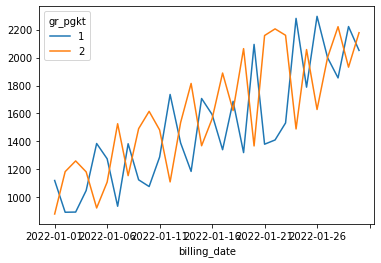

In [0]:
df = pds.pivot_table(df, values='size_mb', index='billing_date', columns='gr_pgkt', aggfunc=np.sum )
df.head(30).plot.line()

In [0]:
df.head()

gr_pgkt,1,2
billing_date,,
2022-01-01,1120.00,880.00
2022-01-02,892.68,1183.32
2022-01-03,893.91,1260.09
2022-01-04,1048.10,1181.90
2022-01-05,1384.80,923.20


Out[36]: <AxesSubplot:xlabel='billing_year,billing_month'>

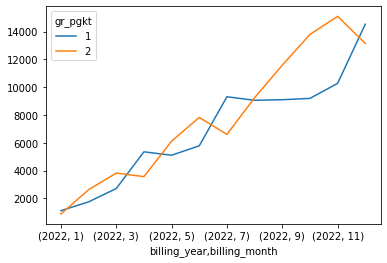

In [0]:
pds.pivot_table(df_report[df_report.billing_day==1], values='size_mb', index=['billing_year',
       'billing_month'], columns='gr_pgkt', aggfunc=np.sum ).plot.line()